<!-- dom:TITLE: Random Forests and Boosting -->
# Random Forests and Boosting
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Jan 28, 2021**

Copyright 1999-2021, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license




## Plan for Day 10

Geron's chapter 7. See also lecture from [STK-IN4300, lecture 9](https://www.uio.no/studier/emner/matnat/math/STK-IN4300/h20/slides/lecture_9.pdf). Chapter 10 (sections 10.1-10.10 are the most relevant ones)  of Hastie et al contains also a good discussion.

[Video on boosting methods by Hastie (the textbook author)](https://www.youtube.com/watch?v=wPqtzj5VZus&ab_channel=H2O.ai).



## Why Voting?

The idea behind boosting, and voting as well can be phrased as follows:
**Can a group of people somehow arrive at highly
reasoned decisions, despite the weak judgement of the individual
members?**

The aim is to create a good classifier by combining several weak classifiers.
**A weak classifier is a classifier which is able to produce results that are only slightly better than guessing at random.**

The basic approach is to apply repeatedly (in boosting this is done in an iterative way) a weak classifier to modifications of the data.
In voting we simply apply the law of large numbers while in boosting we give more weight to misclassified data in
each iteration.  

Decision trees play an important role as our weak classifier. They serve as the basic method. 

## Tossing coins

The simplest case is a so-called voting ensemble. To illustrate this,
think of yourself tossing coins with a biased outcome of 51 per cent
for heads and 49% for tails. With only few tosses,
you may not clearly see this distribution for heads and tails. However, after some
thousands of tosses, there will be a clear majority of heads.  With 2000 tosses
you should see approximately 1020 heads and 980 tails.

We can then state that the outcome is a clear majority of heads. If
you do this ten thousand times, it is easy to see that there is a 97%
likelihood of a majority of heads.

Another example would be to collect all polls before an
election. Different polls may show different likelihoods for a
candidate winning with say a majority  of the popular vote. The majority vote
would then consist in many polls indicating that this candidate will
actually win.

The example here shows how we can implement the coin tossing case,
clealry demostrating that after some tosses we see the [law of large](https://en.wikipedia.org/wiki/Law_of_large_numbers)
numbers kicking in.

## Standard imports first

In [1]:
%matplotlib inline

# Common imports
from IPython.display import Image 
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from IPython.display import Image 
from pydot import graph_from_dot_data
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

## Simple Voting Example, head or tail

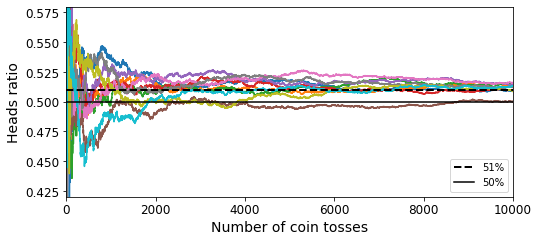

In [2]:

# Common imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("votingsimple")
plt.show()

## Using the Voting Classifier

We can use the voting classifier on other data sets, here the exciting binary case of two distinct objects using the make moons functionality of **Scikit-Learn**.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896
LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## Voting and Bagging

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [6]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Random forests

Random forests provide an improvement over bagged trees by way of a
small tweak that decorrelates the trees. 

As in bagging, we build a
number of decision trees on bootstrapped training samples. But when
building these decision trees, each time a split in a tree is
considered, a random sample of $m$ predictors is chosen as split
candidates from the full set of $p$ predictors. The split is allowed to
use only one of those $m$ predictors. 

A fresh sample of $m$ predictors is
taken at each split, and typically we choose

$$
m\approx \sqrt{p}.
$$

In building a random forest, at
each split in the tree, the algorithm is not even allowed to consider
a majority of the available predictors. 

The reason for this is rather clever. Suppose that there is one very
strong predictor in the data set, along with a number of other
moderately strong predictors. Then in the collection of bagged
variable importance random forest trees, most or all of the trees will
use this strong predictor in the top split. Consequently, all of the
bagged trees will look quite similar to each other. Hence the
predictions from the bagged trees will be highly correlated.
Unfortunately, averaging many highly correlated quantities does not
lead to as large of a reduction in variance as averaging many
uncorrelated quantities. In particular, this means that bagging will
not lead to a substantial reduction in variance over a single tree in
this setting.


## Random Forest Algorithm
The algorithm described here can be applied to both classification and regression problems.

We will grow of forest of say $B$ trees.
1. For $b=1:B$

  * Draw a bootstrap sample from the training data organized in our $\boldsymbol{X}$ matrix.

  * We grow then a random forest tree $T_b$ based on the bootstrapped data by repeating the steps outlined till we reach the maximum node size is reached

1. we select $m \le p$ variables at random from the $p$ predictors/features

2. pick the best split point among the $m$ features using for example the CART algorithm and create a new node

3. split the node into daughter nodes



4. Output then the ensemble of trees $\{T_b\}_1^{B}$ and make predictions for either a regression type of problem or a classification type of problem. 

## Random Forests Compared with other Methods on the Cancer Data

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.95
Test set accuracy with SVM: 0.63
Test set accuracy with Decision Trees: 0.89
Test set accuracy Logistic Regression with scaled data: 0.96
Test set accuracy SVM with scaled data: 0.96
Test set accuracy with Decision Trees and scaled data: 0.92


/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[1.         0.73333333 0.93333333 1.         1.         0.92857143
 1.         0.92857143 0.92857143 0.92857143]
Test set accuracy with Random Forests and scaled data: 0.97


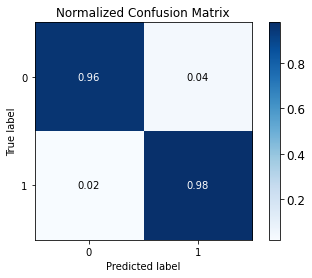

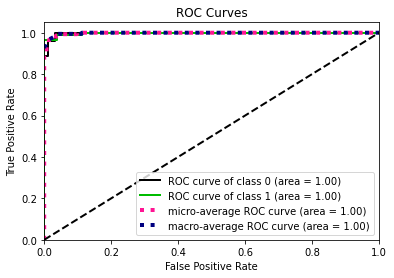

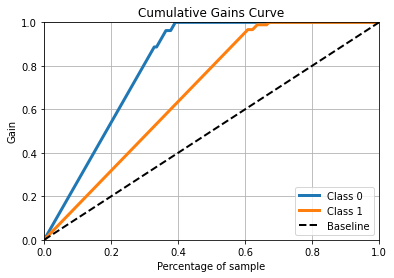

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
# Support vector machine
svm = SVC(gamma='auto', C=100)
svm.fit(X_train, y_train)
print("Test set accuracy with SVM: {:.2f}".format(svm.score(X_test,y_test)))
# Decision Trees
deep_tree_clf = DecisionTreeClassifier(max_depth=None)
deep_tree_clf.fit(X_train, y_train)
print("Test set accuracy with Decision Trees: {:.2f}".format(deep_tree_clf.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Support Vector Machine
svm.fit(X_train_scaled, y_train)
print("Test set accuracy SVM with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Decision Trees
deep_tree_clf.fit(X_train_scaled, y_train)
print("Test set accuracy with Decision Trees and scaled data: {:.2f}".format(deep_tree_clf.score(X_test_scaled,y_test)))


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
# Data set not specificied
#Instantiate the model with 500 trees and entropy as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=500,criterion="entropy")
Random_Forest_model.fit(X_train_scaled, y_train)
#Cross validation
accuracy = cross_validate(Random_Forest_model,X_test_scaled,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Random Forests and scaled data: {:.2f}".format(Random_Forest_model.score(X_test_scaled,y_test)))


import scikitplot as skplt
y_pred = Random_Forest_model.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
y_probas = Random_Forest_model.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

Recall that the cumulative gains curve shows the percentage of the
overall number of cases in a given category *gained* by targeting a
percentage of the total number of cases.

Similarly, the receiver operating characteristic curve, or ROC curve,
displays the diagnostic ability of a binary classifier system as its
discrimination threshold is varied. It plots the true positive rate against the false positive rate.


## Compare  Bagging on Trees with Random Forests

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [10]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.9790209790209791

## Boosting, a Bird's Eye View

The basic idea is to combine weak classifiers in order to create a good
classifier. With a weak classifier we often intend a classifier which
produces results which are only slightly better than we would get by
random guesses.

This is done by applying in an iterative way a weak (or a standard
classifier like decision trees) to modify the data. In each iteration
we emphasize those observations which are misclassified by weighting
them with a factor.


## What is boosting? Additive Modelling/Iterative Fitting

Boosting is a way of fitting an additive expansion in a set of
elementary basis functions like for example some simple polynomials.
Assume for example that we have a function

$$
f_M(x) = \sum_{i=1}^M \beta_m b(x;\gamma_m),
$$

where $\beta_m$ are the expansion parameters to be determined in a
minimization process and $b(x;\gamma_m)$ are some simple functions of
the multivariable parameter $x$ which is characterized by the
parameters $\gamma_m$.

As an example, consider the Sigmoid function we used in logistic
regression. In that case, we can translate the function
$b(x;\gamma_m)$ into the Sigmoid function

$$
\sigma(t) = \frac{1}{1+\exp{(-t)}},
$$

where $t=\gamma_0+\gamma_1 x$ and the parameters $\gamma_0$ and
$\gamma_1$ were determined by the Logistic Regression fitting
algorithm.

As another example, consider the cost function we defined for linear regression

$$
C(\boldsymbol{y},\boldsymbol{f}) = \frac{1}{n} \sum_{i=0}^{n-1}(y_i-f(x_i))^2.
$$

In this case the function $f(x)$ was replaced by the design matrix
$\boldsymbol{X}$ and the unknown linear regression parameters $\boldsymbol{\beta}$,
that is $\boldsymbol{f}=\boldsymbol{X}\boldsymbol{\beta}$. In linear regression we can 
simply invert a matrix and obtain the parameters $\beta$ by

$$
\boldsymbol{\beta}=\left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y}.
$$

In iterative fitting or additive modeling, we minimize the cost function with respect to the parameters $\beta_m$ and $\gamma_m$.


## Iterative Fitting, Regression and Squared-error Cost Function

The way we proceed is as follows (here we specialize to the squared-error cost function)

1. Establish a cost function, here ${\cal C}(\boldsymbol{y},\boldsymbol{f}) = \frac{1}{n} \sum_{i=0}^{n-1}(y_i-f_M(x_i))^2$ with $f_M(x) = \sum_{i=1}^M \beta_m b(x;\gamma_m)$.

2. Initialize with a guess $f_0(x)$. It could be one or even zero or some random numbers.

3. For $m=1:M$

a. minimize $\sum_{i=0}^{n-1}(y_i-f_{m-1}(x_i)-\beta b(x;\gamma))^2$ wrt $\gamma$ and $\beta$

b. This gives the optimal values $\beta_m$ and $\gamma_m$

c. Determine then the new values $f_m(x)=f_{m-1}(x) +\beta_m b(x;\gamma_m)$


We could use any of the algorithms we have discussed till now. If we
use trees, $\gamma$ parameterizes the split variables and split points
at the internal nodes, and the predictions at the terminal nodes.


## Squared-Error Example and Iterative Fitting

To better understand what happens, let us develop the steps for the iterative fitting using the above squared error function.

For simplicity we assume also that our functions $b(x;\gamma)=1+\gamma x$. 

This means that for every iteration $m$, we need to optimize

$$
(\beta_m,\gamma_m) = \mathrm{argmin}_{\beta,\lambda}\hspace{0.1cm} \sum_{i=0}^{n-1}(y_i-f_{m-1}(x_i)-\beta b(x;\gamma))^2=\sum_{i=0}^{n-1}(y_i-f_{m-1}(x_i)-\beta(1+\gamma x_i))^2.
$$

We start our iteration by simply setting $f_0(x)=0$. 
Taking the derivatives  with respect to $\beta$ and $\gamma$ we obtain

$$
\frac{\partial {\cal C}}{\partial \beta} = -2\sum_{i}(1+\gamma x_i)(y_i-\beta(1+\gamma x_i))=0,
$$

and

$$
\frac{\partial {\cal C}}{\partial \gamma} =-2\sum_{i}\beta x_i(y_i-\beta(1+\gamma x_i))=0.
$$

We can then rewrite these equations as (defining $\boldsymbol{w}=\boldsymbol{e}+\gamma \boldsymbol{x})$ with $\boldsymbol{e}$ being the unit vector)

$$
\gamma \boldsymbol{w}^T(\boldsymbol{y}-\beta\gamma \boldsymbol{w})=0,
$$

which gives us $\beta = \boldsymbol{w}^T\boldsymbol{y}/(\boldsymbol{w}^T\boldsymbol{w})$. Similarly we have

$$
\beta\gamma \boldsymbol{x}^T(\boldsymbol{y}-\beta(1+\gamma \boldsymbol{x}))=0,
$$

which leads to $\gamma =(\boldsymbol{x}^T\boldsymbol{y}-\beta\boldsymbol{x}^T\boldsymbol{e})/(\beta\boldsymbol{x}^T\boldsymbol{x})$.  Inserting
for $\beta$ gives us an equation for $\gamma$. This is a non-linear equation in the unknown $\gamma$ and has to be solved numerically. 

The solution to these two equations gives us in turn $\beta_1$ and $\gamma_1$ leading to the new expression for $f_1(x)$ as
$f_1(x) = \beta_1(1+\gamma_1x)$. Doing this $M$ times results in our final estimate for the function $f$. 



## Iterative Fitting, Classification and AdaBoost

Let us consider a binary classification problem with two outcomes $y_i \in \{-1,1\}$ and $i=0,1,2,\dots,n-1$ as our set of
observations. We define a classification function $G(x)$ which produces a prediction taking one or the other of the two values 
$\{-1,1\}$.

The error rate of the training sample is then

$$
\mathrm{\overline{err}}=\frac{1}{n} \sum_{i=0}^{n-1} I(y_i\ne G(x_i)).
$$

The iterative procedure starts with defining a weak classifier whose
error rate is barely better than random guessing.  The iterative
procedure in boosting is to sequentially apply a  weak
classification algorithm to repeatedly modified versions of the data
producing a sequence of weak classifiers $G_m(x)$.

Here we will express our  function $f(x)$ in terms of $G(x)$. That is

$$
f_M(x) = \sum_{i=1}^M \beta_m b(x;\gamma_m),
$$

will be a function of

$$
G_M(x) = \mathrm{sign} \sum_{i=1}^M \alpha_m G_m(x).
$$

## Adaptive Boosting, AdaBoost

In our iterative procedure we define thus

$$
f_m(x) = f_{m-1}(x)+\beta_mG_m(x).
$$

The simplest possible cost function which leads (also simple from a computational point of view) to the AdaBoost algorithm is the
exponential cost/loss function defined as

$$
C(\boldsymbol{y},\boldsymbol{f}) = \sum_{i=0}^{n-1}\exp{(-y_i(f_{m-1}(x_i)+\beta G(x_i))}.
$$

We optimize $\beta$ and $G$ for each value of $m=1:M$ as we did in the regression case.
This is normally done in two steps. Let us however first rewrite the cost function as

$$
C(\boldsymbol{y},\boldsymbol{f}) = \sum_{i=0}^{n-1}w_i^{m}\exp{(-y_i\beta G(x_i))},
$$

where we have defined $w_i^m= \exp{(-y_if_{m-1}(x_i))}$.

## Building up AdaBoost

First, for any $\beta > 0$, we optimize $G$ by setting

$$
G_m(x) = \mathrm{sign} \sum_{i=0}^{n-1} w_i^m I(y_i \ne G_(x_i)),
$$

which is the classifier that minimizes the weighted error rate in predicting $y$.

We can do this by rewriting

$$
\exp{-(\beta)}\sum_{y_i=G(x_i)}w_i^m+\exp{(\beta)}\sum_{y_i\ne G(x_i)}w_i^m,
$$

which can be rewritten as

$$
(\exp{(\beta)}-\exp{-(\beta)})\sum_{i=0}^{n-1}w_i^mI(y_i\ne G(x_i))+\exp{(-\beta)}\sum_{i=0}^{n-1}w_i^m=0,
$$

which leads to

$$
\beta_m = \frac{1}{2}\log{\frac{1-\mathrm{\overline{err}}}{\mathrm{\overline{err}}}},
$$

where we have redefined the error as

$$
\mathrm{\overline{err}}_m=\frac{1}{n}\frac{\sum_{i=0}^{n-1}w_i^mI(y_i\ne G(x_i)}{\sum_{i=0}^{n-1}w_i^m},
$$

which leads to an update of

$$
f_m(x) = f_{m-1}(x) +\beta_m G_m(x).
$$

This leads to the new weights

$$
w_i^{m+1} = w_i^m \exp{(-y_i\beta_m G_m(x_i))}
$$

## Adaptive boosting: AdaBoost, Basic Algorithm

The algorithm here is rather straightforward. Assume that our weak
classifier is a decision tree and we consider a binary set of outputs
with $y_i \in \{-1,1\}$ and $i=0,1,2,\dots,n-1$ as our set of
observations. Our design matrix is given in terms of the
feature/predictor vectors
$\boldsymbol{X}=[\boldsymbol{x}_0\boldsymbol{x}_1\dots\boldsymbol{x}_{p-1}]$. Finally, we define also a
classifier determined by our data via a function $G(x)$. This function tells us how well we are able to classify our outputs/targets $\boldsymbol{y}$. 

We have already defined the misclassification error $\mathrm{err}$ as

$$
\mathrm{err}=\frac{1}{n}\sum_{i=0}^{n-1}I(y_i\ne G(x_i)),
$$

where the function $I()$ is one if we misclassify and zero if we classify correctly. 

## Basic Steps of AdaBoost

With the above definitions we are now ready to set up the algorithm for AdaBoost.
The basic idea is to set up weights which will be used to scale the correctly classified and the misclassified cases.
1. We start by initializing all weights to $w_i = 1/n$, with $i=0,1,2,\dots n-1$. It is easy to see that we must have $\sum_{i=0}^{n-1}w_i = 1$.

2. We rewrite the misclassification error as

$$
\mathrm{\overline{err}}_m=\frac{\sum_{i=0}^{n-1}w_i^m I(y_i\ne G(x_i))}{\sum_{i=0}^{n-1}w_i},
$$

1. Then we start looping over all attempts at classifying, namely we start an iterative process for $m=1:M$, where $M$ is the final number of classifications. Our given classifier could for example be a plain decision tree.

a. Fit then a given classifier to the training set using the weights $w_i$.

b. Compute then $\mathrm{err}$ and figure out which events are classified properly and which are classified wrongly.

c. Define a quantity $\alpha_{m} = \log{(1-\mathrm{\overline{err}}_m)/\mathrm{\overline{err}}_m}$

d. Set the new weights to $w_i = w_i\times \exp{(\alpha_m I(y_i\ne G(x_i)}$.


5. Compute the new classifier $G(x)= \sum_{i=0}^{n-1}\alpha_m I(y_i\ne G(x_i)$.

For the iterations with $m \le 2$ the weights are modified
individually at each steps. The observations which were misclassified
at iteration $m-1$ have a weight which is larger than those which were
classified properly. As this proceeds, the observations which were
difficult to classifiy correctly are given a larger influence. Each
new classification step $m$ is then forced to concentrate on those
observations that are missed in the previous iterations.



## AdaBoost Examples

Using **Scikit-Learn** it is easy to apply the adaptive boosting algorithm, as done here.

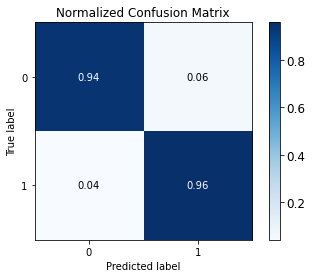

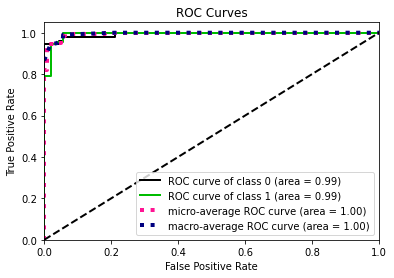

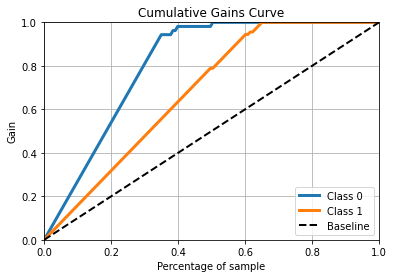

In [11]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train_scaled, y_train)
y_pred = ada_clf.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
y_probas = ada_clf.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

## Gradient boosting: Basics with Steepest Descent/Functional Gradient Descent

Gradient boosting is again a similar technique to Adaptive boosting,
it combines so-called weak classifiers or regressors into a strong
method via a series of iterations.

In order to understand the method, let us illustrate its basics by
bringing back the essential steps in linear regression, where our cost
function was the least squares function.

## The Squared-Error again! Steepest Descent

We start again with our cost function ${\cal C}(\boldsymbol{y}m\boldsymbol{f})=\sum_{i=0}^{n-1}{\cal L}(y_i, f(x_i))$ where we want to minimize
This means that for every iteration, we need to optimize

$$
(\hat{\boldsymbol{f}}) = \mathrm{argmin}_{\boldsymbol{f}}\hspace{0.1cm} \sum_{i=0}^{n-1}(y_i-f(x_i))^2.
$$

We define a real function $h_m(x)$ that defines our final function $f_M(x)$ as

$$
f_M(x) = \sum_{m=0}^M h_m(x).
$$

In the steepest decent approach we approximate $h_m(x) = -\rho_m g_m(x)$, where $\rho_m$ is a scalar and $g_m(x)$ the gradient defined as

$$
g_m(x_i) = \left[ \frac{\partial {\cal L}(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x_i)=f_{m-1}(x_i)}.
$$

With the new gradient we can update $f_m(x) = f_{m-1}(x) -\rho_m g_m(x)$. Using the above squared-error function we see that
the gradient is $g_m(x_i) = -2(y_i-f(x_i))$.

Choosing $f_0(x)=0$ we obtain $g_m(x) = -2y_i$ and inserting this into the minimization problem for the cost function we have

$$
(\rho_1) = \mathrm{argmin}_{\rho}\hspace{0.1cm} \sum_{i=0}^{n-1}(y_i+2\rho y_i)^2.
$$

## Steepest Descent Example

Optimizing with respect to $\rho$ we obtain (taking the derivative) that $\rho_1 = -1/2$. We have then that

$$
f_1(x) = f_{0}(x) -\rho_1 g_1(x)=-y_i.
$$

We can then proceed and compute

$$
g_2(x_i) = \left[ \frac{\partial {\cal L}(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x_i)=f_{1}(x_i)=y_i}=-4y_i,
$$

and find a new value for $\rho_2=-1/2$ and continue till we have reached $m=M$. We can modify the steepest descent method, or steepest boosting, by introducing what is called **gradient boosting**. 

## Gradient Boosting, algorithm

Steepest descent is however not much used, since it only optimizes $f$ at a fixed set of $n$ points,
so we do not learn a function that can generalize. However, we can modify the algorithm by
fitting a weak learner to approximate the negative gradient signal. 

Suppose we have a cost function $C(f)=\sum_{i=0}^{n-1}L(y_i, f(x_i))$ where $y_i$ is our target and $f(x_i)$ the function which is meant to model $y_i$. The above cost function could be our standard  squared-error  function

$$
C(\boldsymbol{y},\boldsymbol{f})=\sum_{i=0}^{n-1}(y_i-f(x_i))^2.
$$

The way we proceed in an iterative fashion is to
1. Initialize our estimate $f_0(x)$.

2. For $m=1:M$, we

a. compute the negative gradient vector $\boldsymbol{u}_m = -\partial C(\boldsymbol{y},\boldsymbol{f})/\partial \boldsymbol{f}(x)$ at $f(x) = f_{m-1}(x)$;

b. fit the so-called base-learner to the negative gradient $h_m(u_m,x)$;

c. update the estimate $f_m(x) = f_{m-1}(x)+h_m(u_m,x)$;


4. The final estimate is then $f_M(x) = \sum_{m=1}^M h_m(u_m,x)$.

## Gradient Boosting, Examples of Regression

/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Max depth: 1
Error: 0.641181526381408
Bias^2: 0.2892779906692578
Var: 0.35190353571215016
0.641181526381408 >= 0.2892779906692578 + 0.35190353571215016 = 0.641181526381408
Max depth: 2
Error: 0.6659177769000277
Bias^2: 0.28922147813300814
Var: 0.3766962987670195
0.6659177769000277 >= 0.28922147813300814 + 0.3766962987670195 = 0.6659177769000276
Max depth: 3
Error: 0.6659175438353938
Bias^2: 0.28922147554796285
Var: 0.37669606828743096
0.6659175438353938 >= 0.28922147554796285 + 0.37669606828743096 = 0.6659175438353938
Max depth: 4
Error: 0.6659175438353938
Bias^2: 0.28922147554796285
Var: 0.37669606828743096
0.6659175438353938 >= 0.28922147554796285 + 0.37669606828743096 = 0.6659175438353938
Max depth: 5
Error: 0.6659175438353938
Bias^2: 0.28922147554796285
Var: 0.37669606828743096
0.6659175438353938 >= 0.28922147554796285 + 0.37669606828743096 = 0.6659175438353938
Max depth: 6
Error: 0.6659175438353938
Bias^2: 0.28922147554796285
Var: 0.37669606828743096
0.6659175438353938 >= 0.289221

/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Max depth: 7
Error: 0.6659175438353938
Bias^2: 0.28922147554796285
Var: 0.37669606828743096
0.6659175438353938 >= 0.28922147554796285 + 0.37669606828743096 = 0.6659175438353938
Max depth: 8
Error: 0.6659175438353938
Bias^2: 0.28922147554796285
Var: 0.37669606828743096
0.6659175438353938 >= 0.28922147554796285 + 0.37669606828743096 = 0.6659175438353938
Max depth: 9
Error: 0.6659175438353938
Bias^2: 0.28922147554796285
Var: 0.37669606828743096
0.6659175438353938 >= 0.28922147554796285 + 0.37669606828743096 = 0.6659175438353938
Max depth: 10
Error: 0.6659175438353938
Bias^2: 0.28922147554796285
Var: 0.37669606828743096
0.6659175438353938 >= 0.28922147554796285 + 0.37669606828743096 = 0.6659175438353938


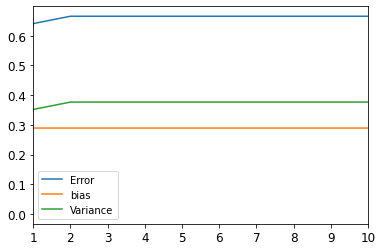

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
from sklearn.metrics import mean_squared_error

n = 100
maxdegree = 11

# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

for degree in range(1,maxdegree):
    model = GradientBoostingRegressor(max_depth=degree, n_estimators=100, learning_rate=1.0)  
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred))**2 )
    variance[degree] = np.mean( np.var(y_pred) )
    print('Max depth:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

plt.xlim(1,maxdegree-1)
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
save_fig("gdregression")
plt.show()

## Gradient Boosting, Classification Example

(426, 30)
(143, 30)
[1.         0.86666667 0.93333333 1.         1.         0.92857143
 1.         0.92857143 0.92857143 0.92857143]
Test set accuracy with Gradient Boosting and scaled data: 0.98


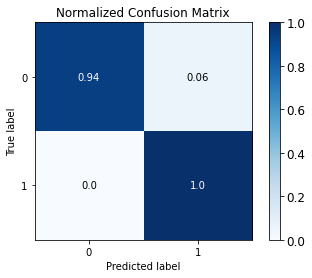

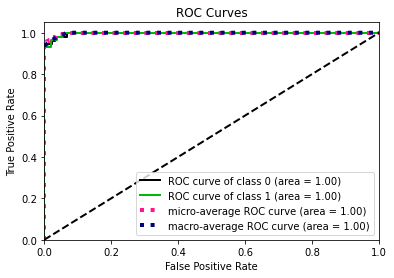

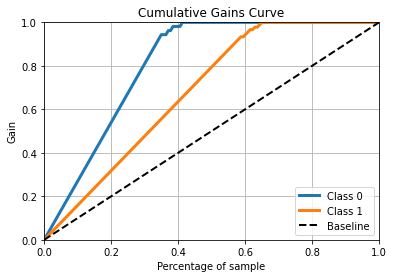

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
import scikitplot as skplt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

gd_clf = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=1.0)  
gd_clf.fit(X_train_scaled, y_train)
#Cross validation
accuracy = cross_validate(gd_clf,X_test_scaled,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Gradient Boosting and scaled data: {:.2f}".format(gd_clf.score(X_test_scaled,y_test)))

import scikitplot as skplt
y_pred = gd_clf.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
save_fig("gdclassiffierconfusion")
plt.show()
y_probas = gd_clf.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
save_fig("gdclassiffierroc")
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
save_fig("gdclassiffiercgain")
plt.show()

## XGBoost: Extreme Gradient Boosting


[XGBoost](https://github.com/dmlc/xgboost) or Extreme Gradient
Boosting, is an optimized distributed gradient boosting library
designed to be highly efficient, flexible and portable. It implements
machine learning algorithms under the Gradient Boosting
framework. XGBoost provides a parallel tree boosting that solve many
data science problems in a fast and accurate way. See the [article by Chen and Guestrin](https://arxiv.org/abs/1603.02754).

The authors design and build a highly scalable end-to-end tree
boosting system. It has  a theoretically justified weighted quantile
sketch for efficient proposal calculation. It introduces a novel sparsity-aware algorithm for parallel tree learning and an effective cache-aware block structure for out-of-core tree learning.

It is now the algorithm which wins essentially all ML competitions!!!

## Regression Case

[08:31:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsaobjective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Max depth: 0
Error: 0.2116781410671183
Bias^2: 0.2116781233523323
Var: 3.552713678800501e-15
0.2116781410671183 >= 0.2116781233523323 + 3.552713678800501e-15 = 0.21167812335233585
[08:31:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsaobjective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Max depth: 1
Error: 0.22975609574631975
Bias^2: 0.18960121839232275
Var: 0.04015487432479858

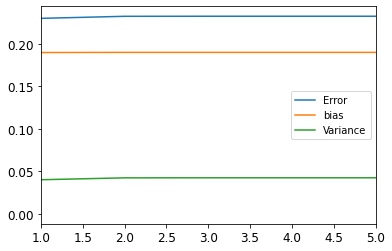

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
from sklearn.metrics import mean_squared_error

n = 100
maxdegree = 6

# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

for degree in range(maxdegree):
    model =  xgb.XGBRegressor(objective ='reg:squarederror', colsaobjective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = degree, alpha = 10, n_estimators = 200)

    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred))**2 )
    variance[degree] = np.mean( np.var(y_pred) )
    print('Max depth:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

plt.xlim(1,maxdegree-1)
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
plt.show()

## Xgboost on the Cancer Data

As you will see from the confusion matrix below, XGBoots does an excellent job on the Wisconsin cancer data and outperforms essentially all agorithms we have discussed till now.

(426, 30)
(143, 30)
Test set accuracy with Random Forests and scaled data: 1.00


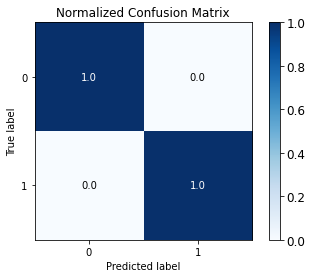

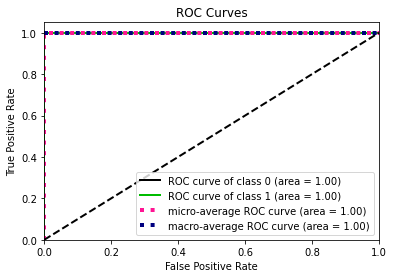

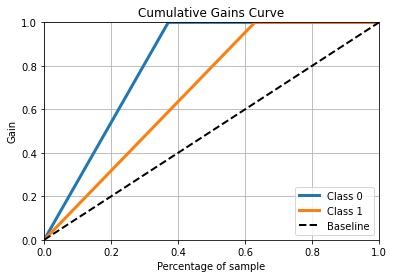

In [16]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scikitplot as skplt
import xgboost as xgb
# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train_scaled,y_train)

y_test = xg_clf.predict(X_test_scaled)

print("Test set accuracy with Random Forests and scaled data: {:.2f}".format(xg_clf.score(X_test_scaled,y_test)))

import scikitplot as skplt
y_pred = xg_clf.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
save_fig("xdclassiffierconfusion")
plt.show()
y_probas = xg_clf.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
save_fig("xdclassiffierroc")
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
save_fig("gdclassiffiercgain")
plt.show()




## Topics we have covered

The course has two central parts

1. Statistical analysis and optimization of data

2. Machine learning

## Statistical analysis and optimization of data

The following topics have been discussed:
1. Basic concepts, expectation values, variance, covariance, correlation functions and errors;

2. Gradient methods for data optimization

3. Estimation of errors using cross-validation, bootstrapping and jackknife methods;

## Machine learning

The following topics will be covered
1. Linear methods for regression and classification:

a. Ordinary Least Squares

b. Ridge regression

c. Lasso regression

d. Logistic regression


5. Neural networks and deep learning:

a. Feed Forward Neural Networks

b. Convolutional Neural Networks

c. Recurrent Neural Networks


4. Decisions trees and ensemble methods:

a. Decision trees

b. Bagging and voting

c. Random forests

d. Boosting and gradient boosting


## Learning outcomes and overarching aims of this course

The course introduces a variety of central algorithms and methods
essential for studies of data analysis and machine learning. The
course is project based and through the various projects, normally
three, you will be exposed to fundamental research problems
in these fields, with the aim to reproduce state of the art scientific
results. The students will learn to develop and structure large codes
for studying these systems, get acquainted with computing facilities
and learn to handle large scientific projects. A good scientific and
ethical conduct is emphasized throughout the course. 

* Understand linear methods for regression and classification;

* Learn about neural network;

* Learn about bagging, boosting and trees

* Learn about basic data analysis;

* Be capable of extending the acquired knowledge to other systems and cases;

* Have an understanding of central algorithms used in data analysis and machine learning;

* Work on numerical projects to illustrate the theory. The projects play a central role and you are expected to know modern programming languages like Python or C++.

## Perspective on Machine Learning

1. Rapidly emerging application area

2. Experiment AND theory are evolving in many many fields. Still many low-hanging fruits.

3. Requires education/retraining for more widespread adoption

4. A lot of “word-of-mouth” development methods

Huge amounts of data sets require automation, classical analysis tools often inadequate. 
High energy physics hit this wall in the 90’s.
In 2009 single top quark production was determined via [Boosted decision trees, Bayesian
Neural Networks, etc.](https://arxiv.org/pdf/0903.0850.pdf)


## Machine Learning Research

Where to find recent results:
1. Conference proceedings, arXiv and blog posts!

2. **NIPS**: [Neural Information Processing Systems](https://papers.nips.cc)

3. **ICLR**: [International Conference on Learning Representations](https://openreview.net/group?id=ICLR.cc/2018/Conference#accepted-oral-papers)

4. **ICML**: International Conference on Machine Learning

5. [Journal of Machine Learning Research](http://www.jmlr.org/papers/v19/) 

6. [Follow ML on ArXiv](https://arxiv.org/list/cs.LG/recent)

## Starting your Machine Learning Project

1. Identify problem type: classification, regression

2. Consider your data carefully

3. Choose a simple model that fits 1. and 2.

4. Consider your data carefully again! Think of data representation more carefully.

5. Based on your results, feedback loop to earliest possible point

## Choose a Model and Algorithm

1. Supervised?

2. Start with the simplest model that fits your problem

3. Start with minimal processing of data

## Preparing Your Data

1. Shuffle your data

2. Mean center your data

  * Why?


3. Normalize the variance

  * Why?


4. **Whitening**

  * Decorrelates data

  * Can be hit or miss


5. When to do train/test split?

## Which Activation and Weights to Choose in Neural Networks

1. RELU? ELU?

2. Sigmoid or Tanh?

3. Set all weights to 0?

  * Terrible idea


4. Set all weights to random values?

  * Small random values


## Optimization Methods and Hyperparameters
1. Stochastic gradient descent

a. Stochastic gradient descent + momentum


2. State-of-the-art approaches:

  * RMSProp

  * Adam

  * and more


Which regularization and hyperparameters? $L_1$ or $L_2$, soft
classifiers, depths of trees and many other. Need to explore a large
set of hyperparameters and regularization methods.


## Resampling

When do we resample?

1. [Bootstrap](https://www.cambridge.org/core/books/bootstrap-methods-and-their-application/ED2FD043579F27952363566DC09CBD6A)

2. [Cross-validation](https://www.youtube.com/watch?v=fSytzGwwBVw&ab_channel=StatQuestwithJoshStarmer)

3. Jackknife and many other

## What's the future like?

Based on multi-layer nonlinear neural networks, deep learning can
learn directly from raw data, automatically extract and abstract
features from layer to layer, and then achieve the goal of regression,
classification, or ranking. Deep learning has made breakthroughs in
computer vision, speech processing and natural language, and reached
or even surpassed human level. The success of deep learning is mainly
due to the three factors: big data, big model, and big computing.

In the past few decades, many different architectures of deep neural
networks have been proposed, such as
1. Convolutional neural networks, which are mostly used in image and video data processing, and have also been applied to sequential data such as text processing;

2. Recurrent neural networks, which can process sequential data of variable length and have been widely used in natural language understanding and speech processing;

3. Encoder-decoder framework, which is mostly used for image or sequence generation, such as machine translation, text summarization, and image captioning.

## Types of Machine Learning, a repetition

The approaches to machine learning are many, but are often split into two main categories. 
In *supervised learning* we know the answer to a problem,
and let the computer deduce the logic behind it. On the other hand, *unsupervised learning*
is a method for finding patterns and relationship in data sets without any prior knowledge of the system.
Some authours also operate with a third category, namely *reinforcement learning*. This is a paradigm 
of learning inspired by behavioural psychology, where learning is achieved by trial-and-error, 
solely from rewards and punishment.

Another way to categorize machine learning tasks is to consider the desired output of a system.
Some of the most common tasks are:

  * Classification: Outputs are divided into two or more classes. The goal is to   produce a model that assigns inputs into one of these classes. An example is to identify  digits based on pictures of hand-written ones. Classification is typically supervised learning.

  * Regression: Finding a functional relationship between an input data set and a reference data set.   The goal is to construct a function that maps input data to continuous output values.

  * Clustering: Data are divided into groups with certain common traits, without knowing the different groups beforehand.  It is thus a form of unsupervised learning.

  * Other unsupervised learning algortihms like **Boltzmann machines**





## Autoencoders: Overarching view

Autoencoders are artificial neural networks capable of learning
efficient representations of the input data (these representations are called codings)  without
any supervision (i.e., the training set is unlabeled). These codings
typically have a much lower dimensionality than the input data, making
autoencoders useful for dimensionality reduction. 

More importantly, autoencoders act as powerful feature detectors, and
they can be used for unsupervised pretraining of deep neural networks.

Lastly, they are capable of randomly generating new data that looks
very similar to the training data; this is called a generative
model. For example, you could train an autoencoder on pictures of
faces, and it would then be able to generate new faces.  Surprisingly,
autoencoders work by simply learning to copy their inputs to their
outputs. This may sound like a trivial task, but we will see that
constraining the network in various ways can make it rather
difficult. For example, you can limit the size of the internal
representation, or you can add noise to the inputs and train the
network to recover the original inputs. These constraints prevent the
autoencoder from trivially copying the inputs directly to the outputs,
which forces it to learn efficient ways of representing the data. In
short, the codings are byproducts of the autoencoder’s attempt to
learn the identity function under some constraints.

[Video on autoencoders](https://www.coursera.org/lecture/building-deep-learning-models-with-tensorflow/autoencoders-1U4L3)

See also A. Geron's textbook, chapter 15.

## Bayesian Machine Learning

This is an important topic if we aim at extracting a probability
distribution. This gives us also a confidence interval and error
estimates.

Bayesian machine learning allows us to encode our prior beliefs about
what those models should look like, independent of what the data tells
us. This is especially useful when we don’t have a ton of data to
confidently learn our model.

[Video on Bayesian deep learning](https://www.youtube.com/watch?v=E1qhGw8QxqY&ab_channel=AndrewGordonWilson)

See also the [slides here](https://github.com/CompPhysics/MachineLearning/blob/master/doc/Articles/lec03.pdf).

## Reinforcement Learning

Reinforcement Learning (RL) is one of the most exciting fields of
Machine Learning today, and also one of the oldest. It has been around
since the 1950s, producing many interesting applications over the
years.

It studies
how agents take actions based on trial and error, so as to maximize
some notion of cumulative reward in a dynamic system or
environment. Due to its generality, the problem has also been studied
in many other disciplines, such as game theory, control theory,
operations research, information theory, multi-agent systems, swarm
intelligence, statistics, and genetic algorithms.

In March 2016, AlphaGo, a computer program that plays the board game
Go, beat Lee Sedol in a five-game match. This was the first time a
computer Go program had beaten a 9-dan (highest rank) professional
without handicaps. AlphaGo is based on deep convolutional neural
networks and reinforcement learning. AlphaGo’s victory was a major
milestone in artificial intelligence and it has also made
reinforcement learning a hot research area in the field of machine
learning.

[Lecture on Reinforcement Learning](https://www.youtube.com/watch?v=FgzM3zpZ55o&ab_channel=stanfordonline).

See also A. Geron's textbook, chapter 16.

## Transfer learning

The goal of transfer learning is to transfer the model or knowledge
obtained from a source task to the target task, in order to resolve
the issues of insufficient training data in the target task. The
rationality of doing so lies in that usually the source and target
tasks have inter-correlations, and therefore either the features,
samples, or models in the source task might provide useful information
for us to better solve the target task. Transfer learning is a hot
research topic in recent years, with many problems still waiting to be studied.

[Lecture on transfer learning](https://www.ias.edu/video/machinelearning/2020/0331-SamoryKpotufe).

## Adversarial learning

The conventional deep generative model has a potential problem: the
model tends to generate extreme instances to maximize the
probabilistic likelihood, which will hurt its performance. Adversarial
learning utilizes the adversarial behaviors (e.g., generating
adversarial instances or training an adversarial model) to enhance the
robustness of the model and improve the quality of the generated
data. In recent years, one of the most promising unsupervised learning
technologies, generative adversarial networks (GAN), has already been
successfully applied to image, speech, and text.

[Lecture on adversial learning](https://www.youtube.com/watch?v=CIfsB_EYsVI&ab_channel=StanfordUniversitySchoolofEngineering).

## Dual learning

Dual learning is a new learning paradigm, the basic idea of which is
to use the primal-dual structure between machine learning tasks to
obtain effective feedback/regularization, and guide and strengthen the
learning process, thus reducing the requirement of large-scale labeled
data for deep learning. The idea of dual learning has been applied to
many problems in machine learning, including machine translation,
image style conversion, question answering and generation, image
classification and generation, text classification and generation,
image-to-text, and text-to-image.

## Distributed machine learning

Distributed computation will speed up machine learning algorithms,
significantly improve their efficiency, and thus enlarge their
application. When distributed meets machine learning, more than just
implementing the machine learning algorithms in parallel is required.


## Meta learning

Meta learning is an emerging research direction in machine
learning. Roughly speaking, meta learning concerns learning how to
learn, and focuses on the understanding and adaptation of the learning
itself, instead of just completing a specific learning task. That is,
a meta learner needs to be able to evaluate its own learning methods
and adjust its own learning methods according to specific learning
tasks.

## The Challenges Facing Machine Learning

While there has been much progress in machine learning, there are also challenges.

For example, the mainstream machine learning technologies are
black-box approaches, making us concerned about their potential
risks. To tackle this challenge, we may want to make machine learning
more explainable and controllable. As another example, the
computational complexity of machine learning algorithms is usually
very high and we may want to invent lightweight algorithms or
implementations. Furthermore, in many domains such as physics,
chemistry, biology, and social sciences, people usually seek elegantly
simple equations (e.g., the Schrödinger equation) to uncover the
underlying laws behind various phenomena. In the field of machine
learning, can we reveal simple laws instead of designing more complex
models for data fitting? Although there are many challenges, we are
still very optimistic about the future of machine learning. As we look
forward to the future, here are what we think the research hotspots in
the next ten years will be.

See the article on [Discovery of Physics From Data: Universal Laws and Discrepancies](https://www.frontiersin.org/articles/10.3389/frai.2020.00025/full)

## Explainable machine learning

Machine learning, especially deep learning, evolves rapidly. The
ability gap between machine and human on many complex cognitive tasks
becomes narrower and narrower. However, we are still in the very early
stage in terms of explaining why those effective models work and how
they work.

**What is missing: the gap between correlation and causation**. Standard Machine Learning is based on what e have called a frequentist approach. 

Most
machine learning techniques, especially the statistical ones, depend
highly on correlations in data sets to make predictions and analyses. In
contrast, rational humans tend to reply on clear and trustworthy
causality relations obtained via logical reasoning on real and clear
facts. It is one of the core goals of explainable machine learning to
transition from solving problems by data correlation to solving
problems by logical reasoning.

**Bayesian Machine Learning is one of the exciting research directions in this field**.

## Quantum machine learning

Quantum machine learning is an emerging interdisciplinary research
area at the intersection of quantum computing and machine learning.

Quantum computers use effects such as quantum coherence and quantum
entanglement to process information, which is fundamentally different
from classical computers. Quantum algorithms have surpassed the best
classical algorithms in several problems (e.g., searching for an
unsorted database, inverting a sparse matrix), which we call quantum
acceleration.

When quantum computing meets machine learning, it can be a mutually
beneficial and reinforcing process, as it allows us to take advantage
of quantum computing to improve the performance of classical machine
learning algorithms. In addition, we can also use the machine learning
algorithms (on classic computers) to analyze and improve quantum
computing systems.

[Lecture on Quantum ML](https://www.youtube.com/watch?v=Xh9pUu3-WxM&ab_channel=InstituteforPure%26AppliedMathematics%28IPAM%29).


[Read interview with Maria Schuld on her work on Quantum Machine Learning](https://physics.aps.org/articles/v13/179?utm_campaign=weekly&utm_medium=email&utm_source=emailalert). See also [her recent textbook](https://www.springer.com/gp/book/9783319964232). 


## Quantum machine learning algorithms based on linear algebra

Many quantum machine learning algorithms are based on variants of
quantum algorithms for solving linear equations, which can efficiently
solve N-variable linear equations with complexity of O(log2 N) under
certain conditions. The quantum matrix inversion algorithm can
accelerate many machine learning methods, such as least square linear
regression, least square version of support vector machine, Gaussian
process, and more. The training of these algorithms can be simplified
to solve linear equations. The key bottleneck of this type of quantum
machine learning algorithms is data input—that is, how to initialize
the quantum system with the entire data set. Although efficient
data-input algorithms exist for certain situations, how to efficiently
input data into a quantum system is as yet unknown for most cases.

## Quantum reinforcement learning

In quantum reinforcement learning, a quantum agent interacts with the
classical environment to obtain rewards from the environment, so as to
adjust and improve its behavioral strategies. In some cases, it
achieves quantum acceleration by the quantum processing capabilities
of the agent or the possibility of exploring the environment through
quantum superposition. Such algorithms have been proposed in
superconducting circuits and systems of trapped ions.

## Quantum deep learning

Dedicated quantum information processors, such as quantum annealers
and programmable photonic circuits, are well suited for building deep
quantum networks. The simplest deep quantum network is the Boltzmann
machine. The classical Boltzmann machine consists of bits with tunable
interactions and is trained by adjusting the interaction of these bits
so that the distribution of its expression conforms to the statistics
of the data. To quantize the Boltzmann machine, the neural network can
simply be represented as a set of interacting quantum spins that
correspond to an adjustable Ising model. Then, by initializing the
input neurons in the Boltzmann machine to a fixed state and allowing
the system to heat up, we can read out the output qubits to get the
result.


## Social machine learning

Machine learning aims to imitate how humans
learn. While we have developed successful machine learning algorithms,
until now we have ignored one important fact: humans are social. Each
of us is one part of the total society and it is difficult for us to
live, learn, and improve ourselves, alone and isolated. Therefore, we
should design machines with social properties. Can we let machines
evolve by imitating human society so as to achieve more effective,
intelligent, interpretable “social machine learning”?

And much more.



## The last words?

Early computer scientist Alan Kay said, **The best way to predict the
future is to create it**. Therefore, all machine learning
practitioners, whether scholars or engineers, professors or students,
need to work together to advance these important research
topics. Together, we will not just predict the future, but create it.